In [ ]:
import os
import re,string
import nltk
import re
import spacy
import pandas as pd
import numpy as np
import networkx as nx
import bs4
nlp = spacy.load('en_core_web_sm')
from tqdm import tqdm


nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

from gensim.models import Word2Vec,LdaMulticore, TfidfModel
from gensim import corpora
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

!pip install python-docx
from docx import Document
import time
from itertools import combinations
from itertools import chain
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 5.5MB 8.8MB/s 
  Created wheel for python-docx: filename=python_docx-0.8.10-cp36-none-any.whl size=184491 sha256=adaa97209053d0cffd48e5b2427e1f2aae696f5b9333f9f6b9dba70fb7c5e327
  Stored in directory: /root/.cache/pip/wheels/18/0b/a0/1dd62ff812c857c9e487f27d80d53d2b40531bec1acecfa47b
Successfully built python-docx


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)
root_dir = '/content/gdrive/My Drive/'
base_dir = root_dir + 'Natural Language Processing/assignments/assignment_2/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
def load_corpus(file_name):
    df = pd.read_csv(base_dir + file_name, index_col = 0)
    titles = df['DSI_Title'].values
    text = df['Text'].values
    return titles, text

In [ ]:
def clean_doc(doc, word2vec = False):
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    stop_words = set(stopwords.words('english'))
    if word2vec == False:
        tokens = doc.split()
        tokens = lower_first_word(tokens)
        tokens = [re_punc.sub('', w) for w in tokens]
        tokens = [word for word in tokens if word.isalpha()]
        tokens = [word for word in tokens if len(word) > 5]
        # # tokens = [word.lower() for word in tokens]
        tokens = [w for w in tokens if not w in stop_words]
        # tokens = [PorterStemmer().stem(word) for word in tokens]
    elif word2vec == True:
        tokens = sent_tokenize(doc)
        tokens = [word.split() for word in tokens]
        tokens = [[re_punc.sub('', word) for word in sent] for sent in tokens]
        tokens = [[word for word in sent if word.isalpha()] for sent in tokens]
        tokens = [[word for word in sent if len(word) > 4] for sent in tokens]
        tokens = [[word.lower() for word in sent] for sent in tokens]
        tokens = [[word for word in sent if not word in stop_words] for sent in tokens]
        # tokens = [[PorterStemmer().stem(word) for word in sent] for sent in tokens]
    return tokens    

In [ ]:
def lower_first_word(tokens):
    for idx, word in enumerate(tokens):
        if '.' in word:
            if idx + 1 != len(tokens):
                tokens[idx + 1] = tokens[idx + 1].lower()
        if idx == 0:
            tokens[idx] = tokens[idx].lower()
    return tokens

In [ ]:
def process_text(file_name, method):
    titles, corpus = load_corpus(file_name)
    processed_text = []
    for text in corpus:
        if method == 'tfidf':
            text = clean_doc(text)
            temp_text = ''
            for word in text:
                temp_text += word + ' '
            processed_text.append(temp_text)
        elif method == 'word2vec':
            text = clean_doc(text, word2vec = True)
            processed_text.extend(text)
        elif method == 'doc2vec':
            text = clean_doc(text)
            processed_text.append(text)            
        elif method == 'entity_extract':            
            # processed_text.append(text.lower().split('.'))
            text = clean_doc(text, word2vec = True)
            temp_text = []
            for sent in text:
                temp_sent = ''
                for word in sent:
                    temp_sent += word + ' '
                temp_text.append(temp_sent)
            processed_text.append(temp_text)
    return titles, processed_text

In [ ]:
def df_tfidf(processed_text):
    titles, text = processed_text
    tfidf = TfidfVectorizer(ngram_range = (1,3))
    tfidf_matrix = tfidf.fit_transform(text)
    matrix = pd.DataFrame(tfidf_matrix.toarray(), columns = tfidf.get_feature_names(),
                      index = titles)
    return matrix

In [ ]:
def get_top_tfidf_terms(df_tfidf, top_num):
    top_term = {}
    for idx in range(len(df_tfidf)):
        row_max = max(df_tfidf.iloc[idx])
        for word in df_tfidf.columns:
            if df_tfidf[word].iloc[idx] == row_max:
                top_term[df_tfidf.index[idx]] = word
    return top_term

In [ ]:
def get_top_tfidf_terms(df_tfidf, top_num, value_range=False):
    top_term = {}
    for idx in range(len(df_tfidf)):
        large_values = df_tfidf.iloc[idx].nlargest(top_num)
        if value_range == False:
            term = large_values.index[top_num - 1]
            value = large_values.values[top_num - 1]
            top_term[df_tfidf.index[idx]] = term
        elif value_range == True:
            term = large_values.index[: (top_num - 1)]
            value = large_values.values[: (top_num - 1)]
            top_term[df_tfidf.index[idx]] = term
    return top_term

In [ ]:
def get_top_raw_terms(all_doc_term_num, doc_term_num):
    docs = process_text('class_corpus.csv', 'doc2vec')
    all_docs = []
    for doc in docs[1]:
        all_docs.extend(doc)
    most_common = Counter(all_docs).most_common(all_doc_term_num)

    all_doc_dict = {}
    for term, _ in most_common:
        for idx, doc in enumerate(docs[1]):
            if term in doc:
                for x_doc, _ in Counter(doc).most_common(doc_term_num):
                    if docs[0][idx] in all_doc_dict.keys():
                        all_doc_dict[docs[0][idx]].append((term, x_doc))
                    else:
                        all_doc_dict[docs[0][idx]] = [(term, x_doc)]
    return all_doc_dict

In [ ]:
def get_entities(sent):
    ent1 = ""
    for tok in nlp(sent):
        if tok.dep_.find("subj") == True:
            ent1 = tok.text
        # elif tok.dep_.find("obj") == True:
        #     ent1 = tok.text
        else:
            continue
    return ent1.strip()

In [ ]:
def get_entities_objects(sent):
    ent1 = ""
    ent2 = ""
    prv_tok_dep = ""
    prv_tok_text = ""
    prefix = ""
    modifier= ""

    for tok in nlp(sent):
        if tok.dep_ != "punct":
            if tok.dep_ == "compound":
                prefix = tok.text
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " " + tok.text
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " " + tok.text
            if tok.dep_.find("subj") == True:
                ent1 = modifier + " " + prefix + " " + tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""  
            if tok. dep_.find("obj") == True:
                ent2 = modifier + " " + prefix + " " + tok.text

            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text

    return (ent1.strip(), ent2.strip())

In [ ]:
def get_relation(sent):
    doc = nlp(sent)
    matcher = spacy.matcher.Matcher(nlp.vocab)
    pattern = [{'DEP':'ROOT'}, 
                {'DEP':'prep','OP':"?"},
                {'DEP':'agent','OP':"?"},  
                {'POS':'ADJ','OP':"?"}] 
    matcher.add("matching_1", None, pattern)
    matches = matcher(doc)
    k = len(matches) - 1
    try:
        span = doc[matches[k][1]:matches[k][2]]
        return span.text
    except:
        span = " "
        return span

In [ ]:
def get_top_terms_entity_extraction():
    docs = process_text('class_corpus.csv', 'entity_extract')
    top_terms_dict = {}
    for idx, doc in enumerate(docs[1]):
        temp_list = []
        for sent in doc:
            temp_list.append(get_entities(sent))
        temp_list = [i for i in temp_list if len(i) > 0]
        temp_list = list(combinations(temp_list, 2))
        top_terms_dict[docs[0][idx]] = temp_list
    return top_terms_dict

In [ ]:
class KnowledgeGraph:
    def __init__(self):
        self.graph = nx.DiGraph()

    def get_top_terms(self, num_terms, method, all_doc_term_num=None, doc_term_num=None):
        top_terms_dict = {}
        if method == 'tfidf':        
            top_terms = get_top_tfidf_terms(df_tfidf(process_text('class_corpus.csv', 
                                            'tfidf')), num_terms, value_range=True)
            for key_review, values in top_terms.items():
                nodes = combinations(values, 2)
                top_terms_dict[key_review] = list(nodes)
        elif method == 'raw':
            top_terms_dict = get_top_raw_terms(all_doc_term_num, doc_term_num)
        elif method == 'entity_extraction':
            top_terms_dict = get_top_terms_entity_extraction()
        return top_terms_dict

    def filter_top_terms(self, term, num_terms, method):
        filtered_terms = {}
        top_terms = self.get_top_terms( num_terms, method, all_doc_term_num=None, doc_term_num=None)
        for key_review, values in top_terms.items():
            for x, y in values:
                if term in x:
                    if key_review in filtered_terms.keys():
                        filtered_terms[key_review].append((x, y))
                    else:
                        filtered_terms[key_review] = [(x, y)]
                elif term in y:
                    if key_review in filtered_terms.keys():
                        filtered_terms[key_review].append((x, y))
                    else:
                        filtered_terms[key_review] = [(x, y)]
        return filtered_terms

    def set_node_attributes(self):
        edge_attributes = nx.get_edge_attributes(self.graph, 'review')
        for keys, value in edge_attributes.items():
            nx.set_node_attributes(self.graph, {keys[0]:value}, 'review')
            nx.set_node_attributes(self.graph, {keys[1]:value}, 'review')

    def get_node_class_dict(self):
        iterable = nx.get_edge_attributes(self.graph, 'review')
        node_class_dict = {}
        for keys, value in iterable.items():
            if keys[0] in node_class_dict.keys():
                if value in node_class_dict[keys[0]]:
                    pass
                else:
                    node_class_dict[keys[0]].append(value)
            else:
                node_class_dict[keys[0]] = [value]
            if keys[1] in node_class_dict.keys():
                if value in node_class_dict[keys[0]]:
                    pass
                else:
                    node_class_dict[keys[1]].append(value)
            else:
                node_class_dict[keys[1]] = [value]
        return node_class_dict

    def process_kg(self, method, num_terms=None, term=None, filtered=False,
                   all_doc_term_num=None, doc_term_num=None):
        if filtered == False:
            data = self.get_top_terms(num_terms, method, all_doc_term_num, doc_term_num)
            for key_review, nodes in data.items():
                self.graph.add_edges_from(nodes, review=key_review)
        elif filtered == True:
            data = self.filter_top_terms(term, num_terms, method)
            for key_review, nodes in data.items():
                self.graph.add_edges_from(nodes, review=key_review)
        self.set_node_attributes()

    def get_top_classes(self, num_degrees):
        top_classes = []
        for node, degree in self.graph.degree:
            if degree > num_degrees:
                top_classes.append(node)
        top_class_dict = {}
        node_class_dict = self.get_node_class_dict()
        for node in top_classes:
            top_class_dict[node] = node_class_dict.get(node)
        return top_class_dict

    def get_reviews_class(self, term):
        node_class_dict = self.get_node_class_dict()
        return node_class_dict.get(term)

    def filter_movie(self, terms):
        filtered_dict = {}
        for term in terms:
            for edges, value in nx.get_edge_attributes(self.graph, 'review').items():
                if value == term:
                    filtered_dict[edges] = value
        kg_filter = nx.DiGraph()
        kg_filter.add_edges_from(filtered_dict.keys(), review=filtered_dict.values())
        self.graph_kg(graph_data=kg_filter)
   
    def graph_kg(self, graph_data=None, attributes=False):
        if graph_data is None:
            graph_data = self.graph
        plt.figure(figsize = [12, 12])
        pos = nx.spring_layout(graph_data, k=1)
        nx.draw(graph_data, with_labels=True, node_color='skyblue', 
                edge_cmap=plt.cm.Blues, pos=pos, width=0.5,
                font_size=20, arrows=False)
        if attributes == True:
            edge_labels = nx.get_edge_attributes(graph_data, 'review')
            nx.draw_networkx_edge_labels(graph_data, pos, labels=edge_labels)

    def graph_abstract_nodes(self, num_degrees, exclude_words=None, attributes=False):
        graph = nx.DiGraph()
        for node, degree in self.graph.degree:
            if exclude_words is not None: 
                if node not in exclude_words:                
                    if degree > num_degrees:
                        graph.add_node(node)
            else:
                if degree > num_degrees:
                    graph.add_node(node)
        for edge in list(self.graph.edges):
            if (edge[0] in graph.nodes) and (edge[1] in graph.nodes):
                graph.add_edge(edge[0], edge[1])
        self.graph_kg(graph_data=graph, attributes=attributes)

    def helper_ifdict(self, dictionary, key, value):
        if key in dictionary.keys():
            dictionary[key].append(value)
        else:
            dictionary[key] = [value]
        return dictionary

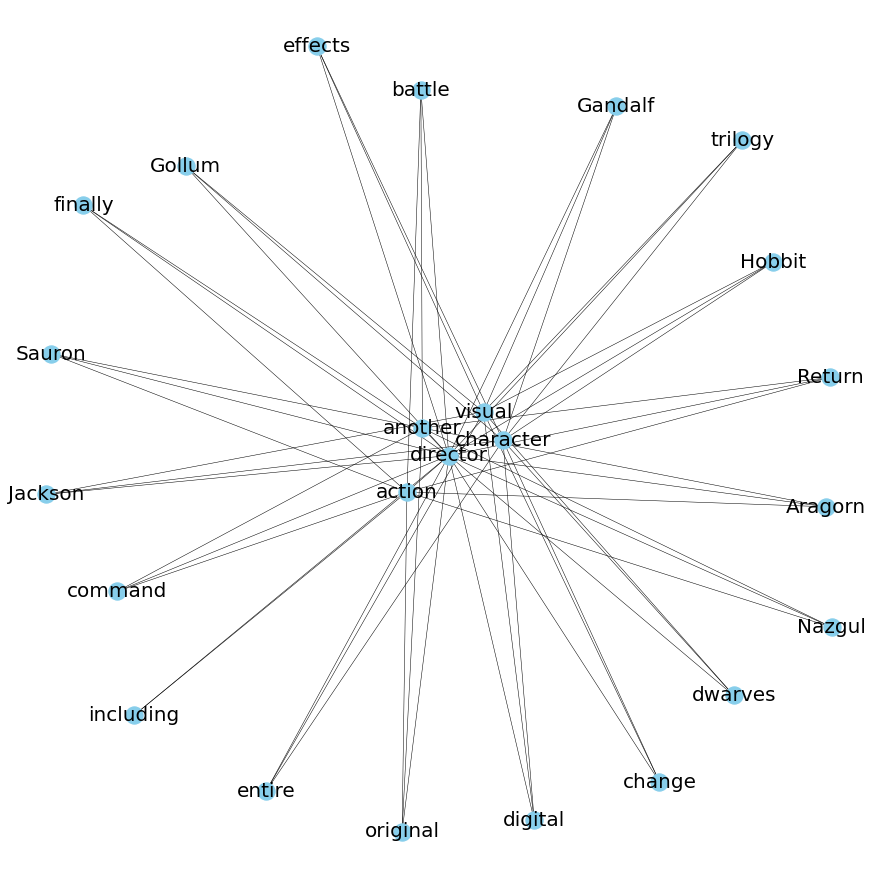

In [ ]:
kg = KnowledgeGraph()
kg.process_kg('raw', num_terms=10, all_doc_term_num=15, doc_term_num=10)
test = kg.filter_movie(['JKS_Doc1_The-Lord-of.docx', 'JKS_Doc2_The-Hobbit_-An.docx'])

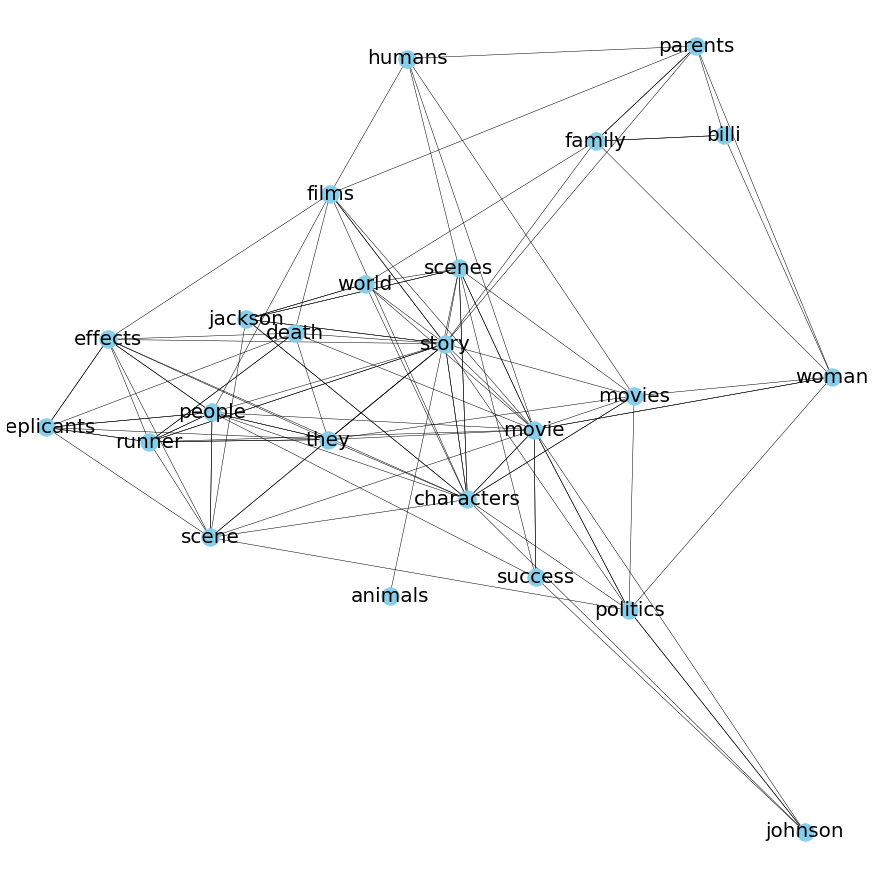

In [ ]:
num_degrees = 45
kg = KnowledgeGraph()
kg.process_kg('entity_extraction')
top_nodes = kg.get_top_classes(num_degrees)
kg.graph_abstract_nodes(num_degrees, exclude_words=['you', 'something', 'things'])

In [ ]:
kg.get_top_terms(5, 'tfidf')

{'AEJ_Doc1_Review_how_to.docx': [('hiccup', 'dragons'),
  ('hiccup', 'toothless'),
  ('hiccup', 'action scenes'),
  ('dragons', 'toothless'),
  ('dragons', 'action scenes'),
  ('toothless', 'action scenes')],
 'AEJ_Doc2_How_to_Train.docx': [('hiccup', 'dragon'),
  ('hiccup', 'toothless'),
  ('hiccup', 'hidden'),
  ('dragon', 'toothless'),
  ('dragon', 'hidden'),
  ('toothless', 'hidden')],
 'AH_Doc1_Coco review charmer.docx': [('miguel', 'musical'),
  ('miguel', 'voiced'),
  ('miguel', 'ernesto'),
  ('musical', 'voiced'),
  ('musical', 'ernesto'),
  ('voiced', 'ernesto')],
 'AH_Doc2_Coco Brings the.docx': [('miguel', 'musical'),
  ('miguel', 'compromise'),
  ('miguel', 'molina'),
  ('musical', 'compromise'),
  ('musical', 'molina'),
  ('compromise', 'molina')],
 'BDL_Doc1_Great-Scott.docx': [('replicant', 'replicants'),
  ('replicant', 'ridley'),
  ('replicant', 'runner'),
  ('replicants', 'ridley'),
  ('replicants', 'runner'),
  ('ridley', 'runner')],
 'BDL_Doc2_Blade-Runner-2049.docx

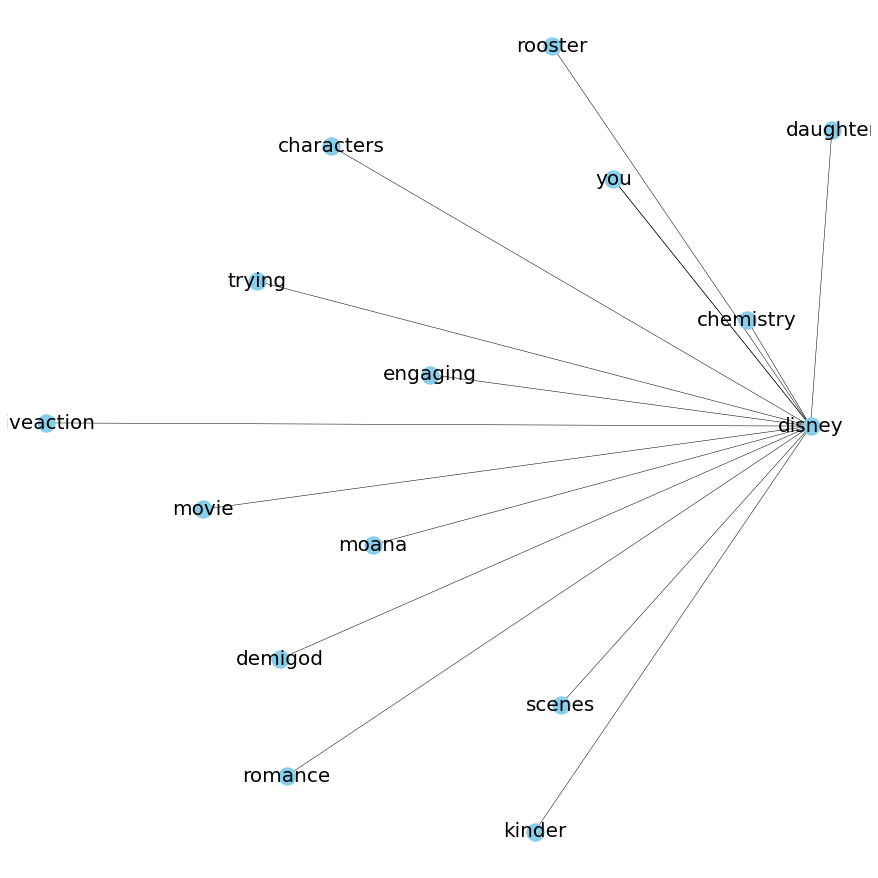

In [ ]:
num_degrees = 175
kg = KnowledgeGraph()
kg.process_kg('entity_extraction', term='disney', filtered=True)
kg.graph_kg()